## 1. Download data and unzip it

In [1]:
!kaggle datasets download -d thoughtvector/customer-support-on-twitter

Dataset URL: https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter
License(s): CC-BY-NC-SA-4.0
100% 169M/169M [00:08<00:00, 33.5MB/s]
100% 169M/169M [00:08<00:00, 21.9MB/s]


In [2]:
!unzip customer-support-on-twitter.zip

Archive:  customer-support-on-twitter.zip
  inflating: sample.csv              
  inflating: twcs/twcs.csv           

In [23]:
!pip install emoji
!pip install adjustText

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import emoji
import string

# the following error happens on mac
import ssl

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

<ipython-input-4-83bbeb8a13b1>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()  # Enable tracking of execution progress


0it [00:00, ?it/s]

In [5]:
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [6]:
# Reading in all the Twitter data
all_data = pd.read_csv('twcs/twcs.csv')
display(all_data.head(10))

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,"@115712 Can you please send us a private message, so that I can gain further details about your account?","5,7",8.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
7,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,"@115713 This is saddening to hear. Please shoot us a DM, so that we can look into this for you. -KC",NaN,12.0
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯,"11,13,14",15.0
9,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,"@115713 We understand your concerns and we'd like for you to please send us a Direct Message, so that we can further assist you. -AA",12,16.0


### Data Info:
* Tweet_id: The unique ID for this tweet
* Author_id: The unique ID for this tweet author (anonymized for non-company users)
* Inbound: Whether or not the tweet was sent (inbound) to a company
* Created_at: When the tweet was created
* Text: The text content of the tweet
* Response_tweet_id: The tweet that responded to this one, if any
* In_response_to_tweet_id: The tweet this tweet was in response to, if any

# 2. Simple EDA and Data Cleaning


In [7]:
apple_data = all_data[(all_data['author_id'] == 'AppleSupport')]
apple_data.dropna(subset = ['in_response_to_tweet_id'],inplace = True)
apple_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103451 entries, 396 to 2697993
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   tweet_id                 103451 non-null  int64  
 1   author_id                103451 non-null  object 
 2   inbound                  103451 non-null  bool   
 3   created_at               103451 non-null  object 
 4   text                     103451 non-null  object 
 5   response_tweet_id        30465 non-null   object 
 6   in_response_to_tweet_id  103451 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 5.6+ MB


<ipython-input-7-c295790d443c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_data.dropna(subset = ['in_response_to_tweet_id'],inplace = True)


In [8]:
# # Converting the IDs to integers to match the tweet_id column for joining
apple_data.in_response_to_tweet_id = apple_data.in_response_to_tweet_id.astype('int64')

# # Doing an inner join to get the respective tweets back from the all_data from and get the response texts. So one question-answer pair is put on one record
apple_data = pd.merge(all_data[['tweet_id','text']],apple_data,left_on='tweet_id', right_on='in_response_to_tweet_id')

# # Dropping the columns that doesn't encode useful information and renaming the columns nicely for intepretability
apple_data.drop(['tweet_id_x','tweet_id_y','in_response_to_tweet_id','inbound'], axis = 1, inplace = True)

# # Renaming the columns for intepretability
apple_data.rename(columns = {'text_x':'inbound_text','text_y':'outbound_text'},inplace = True)


<ipython-input-8-93dd01a5433b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_data.in_response_to_tweet_id = apple_data.in_response_to_tweet_id.astype('int64')


In [9]:
final_data = apple_data['inbound_text']
final_data.dropna(inplace=True)
display(final_data.head(10))
display(final_data.info())


0                                                                     @AppleSupport The newest update. I️ made sure to download it yesterday.
1                                                                                                      @AppleSupport  https://t.co/NV0yucs0lB
2                                                                @AppleSupport Tried resetting my settings .. restarting my phone .. all that
3                                                                            @AppleSupport This is what it looks like https://t.co/XCQU2l4xUB
4                                                                                        @AppleSupport I️ have an iPhone 7 Plus and yes I️ do
5                                                                                       @AppleSupport I️ need answers because it’s annoying 🙃
6    Hey @AppleSupport and anyone else who upgraded to ios11.1, are y’all having issues with capital “I️” in the Mail app? As it puts in “A”?
7     

<class 'pandas.core.series.Series'>
Index: 103381 entries, 0 to 103380
Series name: inbound_text
Non-Null Count   Dtype 
--------------   ----- 
103381 non-null  object
dtypes: object(1)
memory usage: 1.6+ MB


None

# 3. Text Pre-processing


In [10]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
# the above is not needed on Windows

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
tw_tokenizer = TweetTokenizer(reduce_len=True)
nlp = spacy.load("en_core_web_sm")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:

str_punct = string.punctuation

def remove_stopwords_lemmatizer(text):
    sent = []
    # doc = nlp(text)

    for token in tw_tokenizer.tokenize(text):
        if (token not in stop_words):
            sent.append(lemmatizer.lemmatize(token))
    return " ".join(sent)

def customize_stopwords():
  fillerWord = ("so","yeah","okay","um","uh","mmm","ahan","uh","huh","ahm","oh","sooo","uh","huh","yeh","yah","hmm","bye", "a", "able", "about", "above", "abst", "accordance", "i", "without", "according", "accordingly", "across", "act", "actually", "added", "adj", "affected", "affecting", "affects", "after", "afterwards", "again", "against", "ah", "all", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "apparently", "approximately", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "auth", "available", "away", "awfully", "b", "back", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "between", "beyond", "biol", "both", "brief", "briefly", "but", "by", "c", "ca", "came", "can", "cannot", "can't", "cause", "causes", "certain", "certainly", "co", "com", "come", "comes", "contain", "containing", "contains", "could", "couldnt", "d", "date", "did", "didn't", "different", "do", "does", "doesn't", "doing", "done", "don't", "down", "downwards", "during", "e", "each", "ed", "edu", "effect", "eg", "eight", "eighty", "either", "else", "elsewhere", "end", "ending", "enough", "especially", "et", "et-al", "etc", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "except", "f", "far", "few", "ff", "fifth", "first", "five", "fix", "followed", "following", "follows", "for", "former", "formerly", "forth", "found", "four", "from", "further", "furthermore", "g", "gave", "get", "gets", "getting", "give", "given", "gives", "giving", "go", "goes", "gone", "got", "gotten", "h", "had", "happens", "hardly", "has", "hasn't", "have", "haven't", "having", "he", "hed", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hers", "herself", "hes", "hi", "hid", "him", "himself", "his", "hither", "home", "how", "howbeit", "however", "hundred", "i", "id", "ie", "if", "i'll", "im", "immediate", "immediately", "importance", "important", "in", "inc", "indeed", "index", "information", "instead", "into", "invention", "inward", "is", "isn't", "it", "itd", "it'll", "its", "itself", "i've", "j", "just", "k", "keep", "keeps", "kept", "kg", "km", "know", "known", "knows", "l", "largely", "last", "lately", "later", "latter", "latterly", "least", "less", "lest", "let", "lets", "like", "liked", "likely", "line", "little", "'ll", "look", "looking", "looks", "ltd", "m", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "million", "miss", "ml", "more", "moreover", "most", "mostly", "mr", "mrs", "much", "mug", "must", "my", "myself", "n", "na", "name", "namely", "nay", "nd", "near", "nearly", "necessarily", "necessary", "need", "needs", "neither", "never", "nevertheless", "new", "next", "nine", "ninety", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "now", "nowhere", "o", "obtain", "obtained", "obviously", "of", "off", "often", "oh", "ok", "okay", "old", "omitted", "on", "once", "one", "ones", "only", "onto", "or", "ord", "other", "others", "otherwise", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "owing", "own", "p", "page", "pages", "part", "particular", "particularly", "past", "per", "perhaps", "placed", "please", "plus", "poorly", "possible", "possibly", "potentially", "pp", "predominantly", "present", "previously", "primarily", "probably", "promptly", "proud", "provides", "put", "q", "que", "quickly", "quite", "qv", "r", "ran", "rather", "rd", "re", "readily", "really", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "respectively", "resulted", "resulting", "results", "right", "run", "s", "said", "same", "saw", "say", "saying", "says", "sec", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sent", "seven", "several", "shall", "she", "shed", "she'll", "shes", "should", "shouldn't", "show", "showed", "shown", "showns", "shows", "significant", "significantly", "similar", "similarly", "since", "six", "slightly", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "specifically", "specified", "specify", "specifying", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure	t", "take", "taken", "taking", "tell", "tends", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'll", "theyre", "they've", "think", "this", "those", "thou", "though", "thoughh", "thousand", "throug", "through", "throughout", "thru", "thus", "til", "tip", "to", "together", "too", "took", "toward", "towards", "tried", "tries", "truly", "try", "trying", "ts", "twice", "two", "u", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "up", "upon", "ups", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "v", "value", "various", "'ve", "very", "via", "viz", "vol", "vols", "vs", "w", "want", "wants", "was", "wasnt", "way", "we", "wed", "welcome", "we'll", "went", "were", "werent", "we've", "what", "whatever", "what'll", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "whose", "why", "widely", "willing", "wish", "with", "within", "wont", "words", "world", "would", "wouldnt", "www", "x", "y", "yes", "yet", "you", "youd", "you'll", "your", "youre", "yours", "yourself", "yourselves", "you've", "z", "zero",'Heh','heh','language','know', 'wow', 'hah', 'hey','really','year', 'yeah','wtf', 'meh', 'oops', 'nah', 'yea','doesnt','dont','make', 'huh', 'mar', 'umm', 'like', 'think','right', 'duh', 'sigh', 'wheres', 'hmm', 'interesting', 'article','good','know', 'say', 'hello', 'yup','im', 'ltsarcasmgt', 'hehe', 'blah', 'nope', 'ouch', 'uh')
  stop_words.add(fillerWord)

  keep_words =["not","nor","neither", "no"]
  for i in keep_words:
      stop_words.discard(i)


# Converting emojis to words
def convert_emoji_to_text(emoji_text):
    text_with_aliases = emoji.demojize(emoji_text)
    return text_with_aliases


def clean_text(text):

    text = str(text).lower()
    # replace abbreviation correct misspelling words
    text = preprocess_chat_text(text)
    # text = convert_emoticons(text)
    text = convert_emoji_to_text(text)

    text = re.sub(r"https?://t.co/\S+", " ", str(text))
    text = re.sub(r"@\w+", " ", text)  # Remove placeholder [+XYZ chars]
    text = re.sub(r"\[\w+\]", " ", text)  # Remove placeholder [+XYZ chars]
    text = re.sub(r"[(/)*-]", " ", text)
    text = re.sub(r"[\.]{2,}", " ", text)  # Remove ellipsis
    text = re.sub(r"\d+", " ", text)
    # text = re.sub(r"[#@]", " ", text) # remove hashtag signs
    text = re.sub(r"yo{1,}u{1,}", "you", text)
    text = re.sub(r"ah{1,}", " relief, happy ", text)
    text = re.sub(r"alaugh\w+", "laugh", text)
    text = re.sub(r"angry{1,}", "angry", text)
    text = re.sub(r"boo{1,}m", "boom", text)
    text = re.sub(r"cherr{1,}yy{1,}", "cherry", text)
    text = re.sub(r"class{1,}y", "classy", text)
    text = re.sub(r"cu{2,}te", "cute", text)
    text = re.sub(r"fu{2,}ck\w+", "fuck", text)
    text = re.sub(r"him{2,}", "him", text)
    text = re.sub(r"(no){2,}yes", " finally ok ", text)
    text = re.sub(r"yee{1,}ss{1,}", "yes", text)
    text = re.sub(r"(no){2,}", "no", text)
    text = re.sub(r"agaa{1,}in", "again", text)
    text = re.sub(r"a{1,}g{0,}h{1,}", "angry", text)
    text = re.sub(r"a{1,}laug{0,}h{1,}", "laugh", text)
    text = re.sub(r"[" + str_punct + r"]", "", text)
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content

    text = remove_stopwords_lemmatizer(text)
    return text


def preprocess_chat_text(text):
    # Expand common abbreviations
    abbreviation_mapping = {
        ":d": "laugh",
        "lol": "laugh out loud",
        "brb": "be right back",
        "omg": "oh my god",
        "sec": "second",
        'idk': "i do not know",
        "doesn't": "does not",
        "don't": "do not",
        "didn't": "did not",
        "isn't": "is not",
        "hadn't": "had not",
        "haven't": "have not",
        "mightn't": "might not",
        "needn't": "need not",
        "wasn't": "was not",
        "weren't": "were not",
        "won't": "will not",
        "shouldn't": "should not",
        "lmao": "laughing my ass off",
        "'ve": " have",
        "I'm": "I am",
        "'s": " is",
        "can't": "can not",
        "it's": "it is",
        "you're": "you are",
        "nvm": "never mind",
        "haha": "laugh",
        "it'll": "it will",
        "'ll": " will",
        "r/": " are ",
        # Add more mappings as needed
    }

    # Replace abbreviations with their expanded forms
    for abbreviation, expansion in abbreviation_mapping.items():
        text = text.replace(abbreviation, expansion)

    emonicons_mapping = {
       ":)": "happy",
       ":-)": "happy",
       ";)" : "happy winking",
        ";-)": "happy winking",
        ":P": "sticking out tongue",
        ":-P": "sticking out tongue",
        ":D" :	"open-mouthed grin",
        ":-D": "open-mouthed grin",
        ":(":	"unhappy",
        ":-(": "unhappy",
        ":~(": "crying",
        ":-|": "unemotional",
        ">:-(": "very unhappy",
        "8-)": "wide eyed happyness",
        ":-O": "surprise",
        ":o": "surprise",
        "8-O": "wide-eyed shouting",
        ">8-O": "mad wide-eyed shouting",
        "|-|": "asleep",
        "==|:-)": "silly",
    }

    # Replace emoticons with their mapping words
    for emoticon, correction in emonicons_mapping.items():
        text = text.replace(emoticon, correction)
    return text

def clean_text_wrapper(series):
    customize_stopwords()

    print("Start cleaning...")
    result = series.progress_apply(clean_text)
    # df_test['cleaned_text'] = df_test.inbound_text.apply(clean_text)
    print("done!")
    return result


We see that after preprocessing, we will remove the handles which is what applesupport and 115858 is in the visualization above. For now, I briefly visualized the top 10 most common tokens to show that my data as it currently is quite dirty, they will definitely skew and ruin my results if I don't do preprocessing!

### Save the processed data to apple_data dataframe

In [12]:
cleaned_data = clean_text_wrapper(final_data)
cleaned_data.dropna()
display(cleaned_data.info)

Start cleaning...


  0%|          | 0/103381 [00:00<?, ?it/s]

done!


<bound method Series.info of 0                                                                        newest update made sure download yesterday
1                                                                                                                  
2                                                                          tried resetting setting restarting phone
3                                                                                                         look like
4                                                                                                   iphone plus yes
                                                            ...                                                    
103376                                      worst experience store today everyone know stick apple teamapple pissed
103377    sooo iphone aint working touch screen aint responding aint dropped no water damage sooo get shit situated
103378                                                                                                       really
103379                apps crashing left right o spontaneously freezing restarting glitchy siri voice command using
103380                                                                            break phone facewithraisedeyebrow
Name: inbound_text, Length: 103381, dtype: object>

In [15]:
display(cleaned_data.head(100))


0                                          newest update made sure download yesterday
1                                                                                    
2                                            tried resetting setting restarting phone
3                                                                           look like
4                                                                     iphone plus yes
                                           ...                                       
95                                                                                   
96    tell ’ ’ updated phone twice ’ type letter without getting letter question mark
97                 new one tauntingly pretend saved ’ click try send grey screen show
98                 whenever try see photo ’ taken iphone show ’ reset ’ restored help
99                                                      “ ” shit annoying yo fix shit
Name: inbound_text, Length: 100, dtype: object

# 4. Use TfidfVectorizer to Choose Top Ranking Words


In [18]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument, Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=3000, ngram_range = (1, 3),  min_df=0.005, max_df=0.9, norm="l2")
tfidf_result = tfidf_vectorizer.fit_transform(cleaned_data)
tfidf_tokens = tfidf_vectorizer.get_feature_names_out()
print("The first 20 tokens in the token list:", tfidf_tokens[:20])

The first 20 tokens in the token list: ['able' 'access' 'account' 'actually' 'ago' 'alarm' 'already' 'also'
 'always' 'amp' 'android' 'annoying' 'another' 'anymore' 'anyone'
 'anyone else' 'anything' 'app' 'app store' 'apple']


In [19]:
print("Number of tokens: ",len(tfidf_tokens))
## sum tfidf frequency of each token through all of documents
sums = tfidf_result.sum(axis=0)

display(sums)

## connecting term to its sums frequency
data = []
for col, term in enumerate(tfidf_tokens):
    data.append((term, sums[0,col]))

## You can sort words based IDF score or create a word cloud for better data visualization.
print("done statistics!")
ranking = pd.DataFrame(data, columns=['token','rank'])
ranking.sort_values('rank', inplace=True, ascending=False)

weights = {}
for index, row in ranking.iterrows() :
    weights.update({row['token'] : row['rank']})

print("Tokens sorted based on it's score.")


Number of tokens:  383


matrix([[ 406.78593728,  250.32568401,  438.22619202,  257.67067677,
          381.44933031,  294.06649982,  722.314211  ,  697.41833144,
          361.8805367 , 1125.50871697,  296.50045157,  763.92644226,
          362.1846777 ,  371.63106152,  501.97722244,  285.15792704,
          495.19907177, 1541.40175113,  243.00143783, 2416.87725799,
          243.39937618,  422.05860056,  224.82267787,  301.07778254,
         1284.19860416,  268.83610916,  292.31516483,  304.75562734,
          287.39026637,  236.70741443, 1162.88469075,  356.01040938,
          257.15749227, 2341.14684183,  298.99456929,  613.52957668,
          279.29333834,  261.14096701,  526.34308335,  327.56102118,
          817.05568238,  261.03225108, 1149.99957682,  461.47436657,
          385.97287432,  865.32051206,  245.99411242,  376.84989191,
          268.92899127,  278.50318785,  286.69322341,  258.78541542,
          250.79838072,  526.32539941,  260.30358257,  574.88707232,
          419.42151948,  352.33547

done statistics!
Tokens sorted based on it's score.


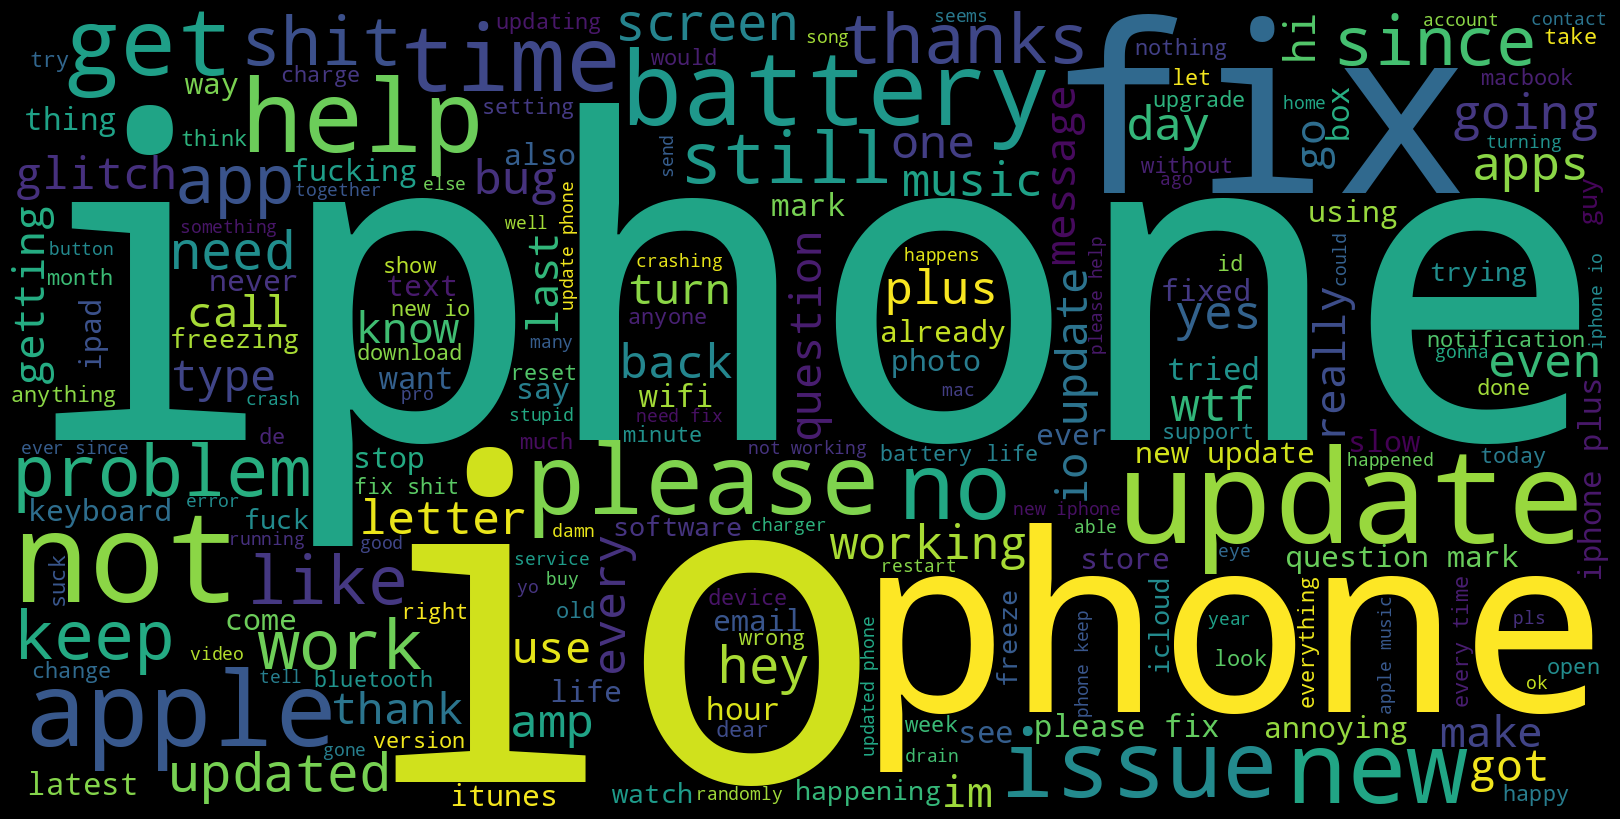

In [20]:
""" Accepts dictionary of words with it's weight and plot word cloud.

Parameters:
    weights (dict) : list of tokens with it's weight

Returns:
    Plots word cloud
"""
import wordcloud
def create_wordcloud(weights):
    plt.figure(figsize=(16,12), facecolor='k')
    wc = wordcloud.WordCloud(width=1600, height=800)
    wc.generate_from_frequencies(weights)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

create_wordcloud(weights)

In [21]:
ranking.tail(10)

,token,rank
283,shit together,235.008030
373,worse,233.450943
196,mark box,231.199894
189,macbook pro,231.120897
128,half,229.322357
218,no longer,227.763870
180,lock screen,227.672033
255,question mark box,224.953716
22,apple store,224.822678
211,new io update,206.574865


# 5. Use Word2Vec to Vectorize the Words

In [22]:
tokenized_docs = cleaned_data.str.split()
print("Generating word vectors...")
w2c_vectorizer = Word2Vec(sentences=tokenized_docs, vector_size=300, workers=1, seed=42)
print("Done!")

Generating word vectors...
Done!


## Visualize the most frequent words with TSNE (Most frequent words come from TFIDF and word vector comes from Word2Vec)

In [24]:
""" Accepts list of words with its list of vectors

Parameters:
    wvs (list) : list of word vectors
    words (list) : List of words to be considered for visualiztion.
"""

from sklearn.manifold import TSNE
from adjustText import adjust_text

def visualize_word_embedding(words, wvs) :

    tsne = TSNE(n_components=2, n_iter=5000, random_state=0, perplexity=5)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(wvs)

    plt.figure(num=1, figsize=(20, 20))
    plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
    texts = []

    print(len(words),wvs.shape, T.shape)
    for word, x, y in zip(words, T[:, 0], T[:, 1]):
        texts.append(plt.annotate(word, xy=(x+0.2, y), fontsize=10))

    adjust_text(texts)
    plt.show()

In [25]:
top_words = ranking[:]
display(top_words)

top_words_ls = list(top_words['token'])

# find the word vectors for those high frequency words
top_words_new = []
top_words_vector_ls = []
for word in top_words_ls:
    # some words chosen by tfidf are not chosen (included) in word2vec vocabulary due to the setting when creating the model
    if word in w2c_vectorizer.wv:
        top_words_new.append(word)
        top_words_vector_ls.append(w2c_vectorizer.wv[word])

top_words_vector_ls = np.array(top_words_vector_ls)
display(top_words_vector_ls)

,token,rank
154,iphone,4918.220095
150,io,4909.387171
236,phone,4823.926415
104,fix,4261.019847
344,update,4001.755281
...,...,...
218,no longer,227.763870
180,lock screen,227.672033
255,question mark box,224.953716
22,apple store,224.822678


array([[ 0.16040312, -0.02136177,  0.54117   , ...,  0.11374369,
         0.07806688, -0.00852057],
       [-0.78143144, -0.77608556,  0.30792823, ...,  1.1521626 ,
         0.3909276 ,  0.35384998],
       [ 0.27654982,  0.06805031,  0.13723439, ...,  0.9539128 ,
         0.33389091, -0.04576669],
       ...,
       [ 0.3468169 , -0.08996245,  0.20113803, ..., -0.34167436,
        -0.24280672,  0.06992621],
       [-0.46462202, -0.34555706,  0.45591924, ...,  0.19359016,
         0.07322877,  0.5150838 ],
       [-0.0420849 , -0.45882437,  0.04469812, ...,  0.4206628 ,
         0.57590073,  0.01647566]], dtype=float32)

329 (329, 300) (329, 2)


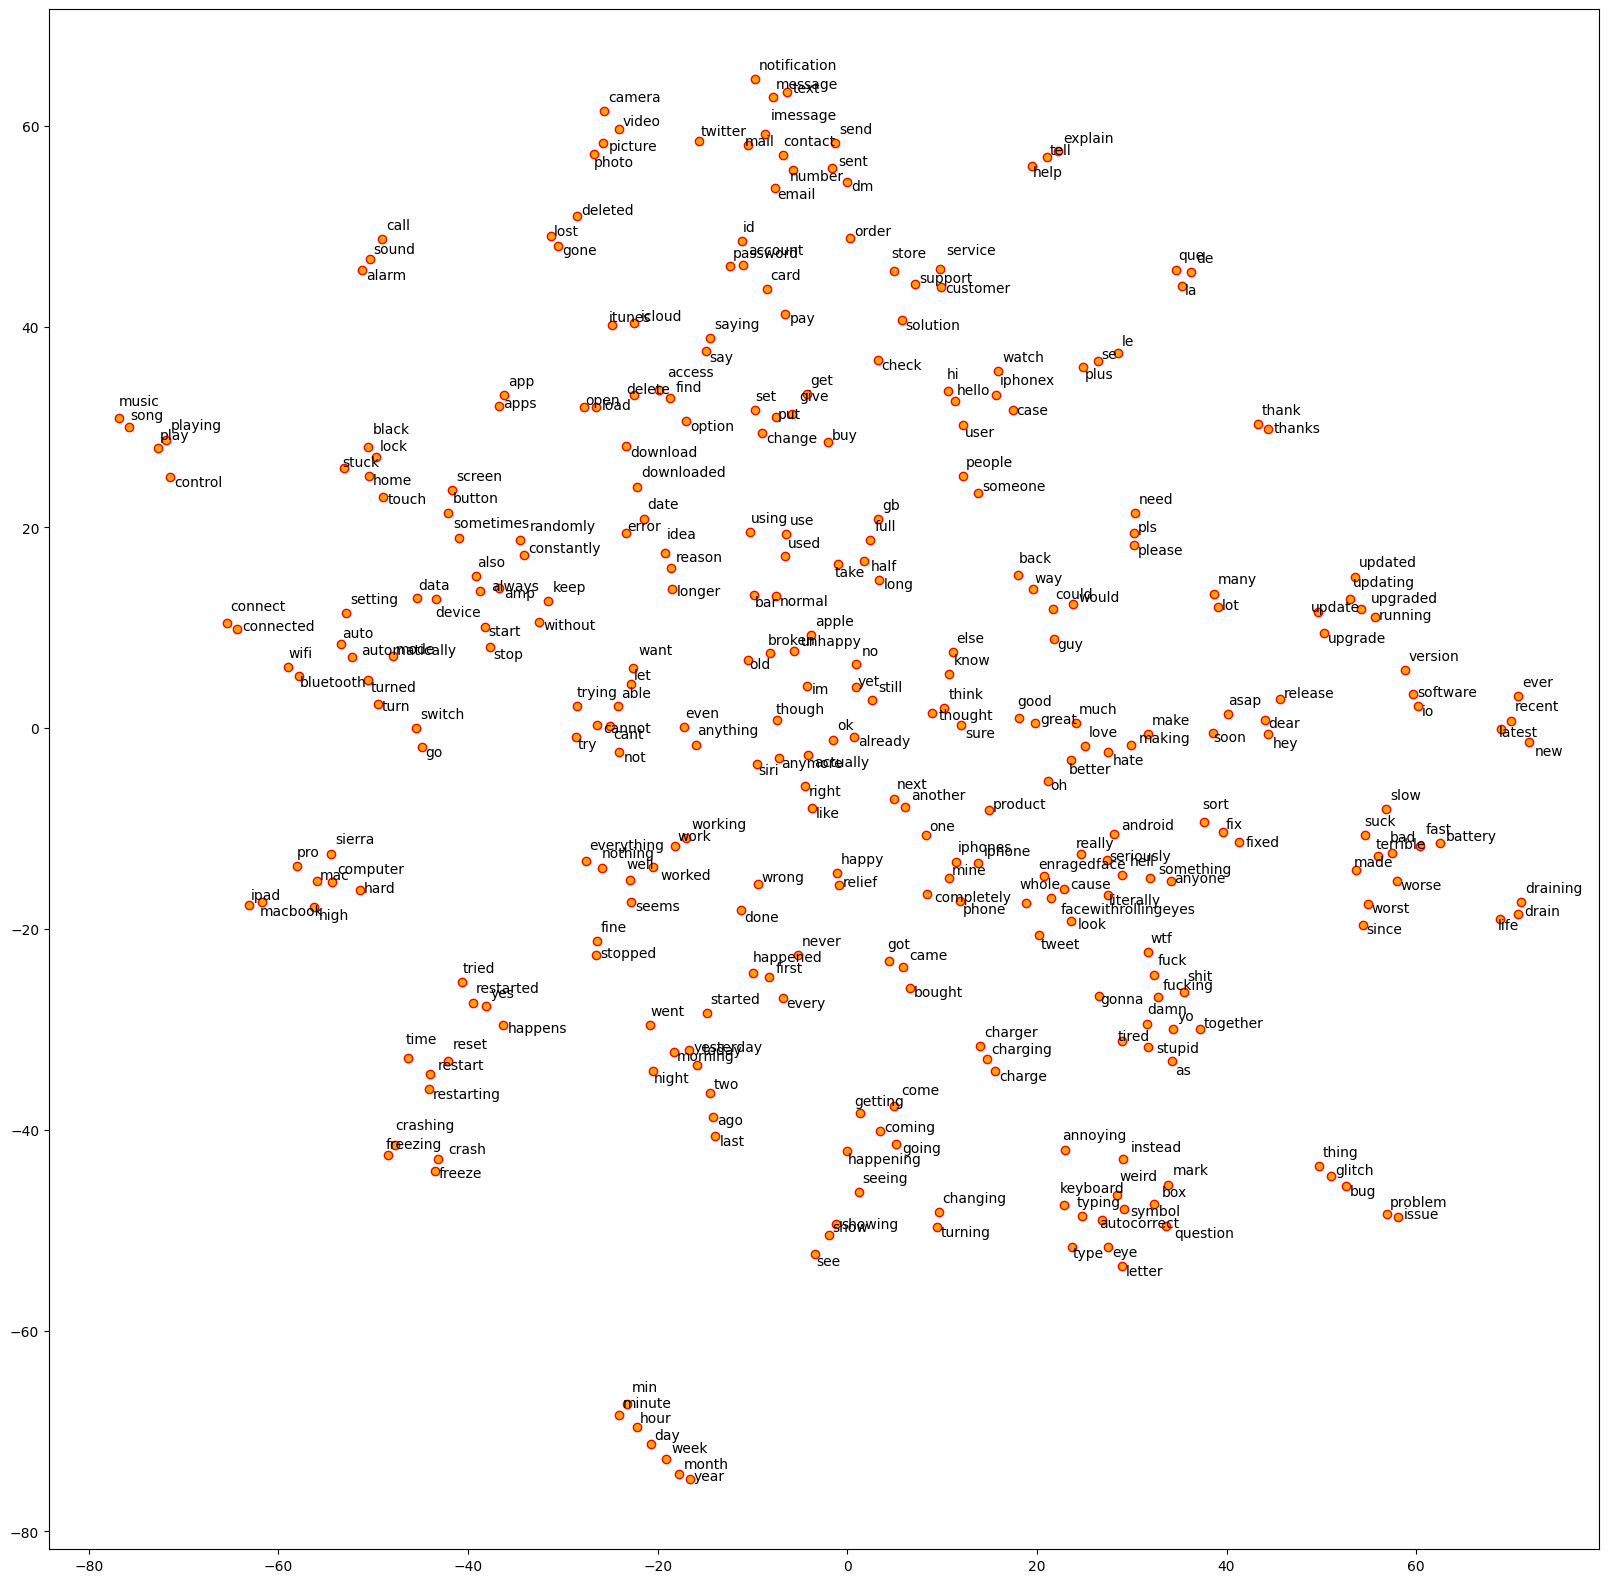

In [26]:
visualize_word_embedding(top_words_new, top_words_vector_ls)

In [ ]:
possible_intents = ['charger', 'apple_music', "bluetooth_wifi_setting", "id_and_password", "camera_video", "slow_performance", "keyboard_typing", "upgrade_software", "battery", "cloud", "screen lock", "restart", "freezing", "crashing", "home_button"]
display(possible_intents)

['charger',
 'apple_music',
 'bluetooth_wifi_setting',
 'id_and_password',
 'camera_video',
 'slow_performance',
 'keyboard_typing',
 'upgrade_software',
 'battery',
 'cloud',
 'screen lock',
 'restart',
 'freezing',
 'crashing',
 'home_button']

### Further fitler the data to check and verify the keywords for the intent

In [27]:
cleaned_data[cleaned_data.str.contains("bluetooth")]

62                                                                                                                            still no reliable bluetooth iphone
343                                                                                                                          updated iphone bluetooth constantly
441                                                                                                           not tried yet little bluetooth sound bar home soon
442                                                         bluetooth connection iphone x infiniti terrible garbled scratchy cutting gt time not happen w iphone
475                         sometimes theyre connected sometimes theyre not sometimes even say bluetooth not available bar top yet one connected started updated
                                                                                   ...                                                                          
103036                            

# Step 5 (Alternative). Use Doc2Vec to Visualize TSNE



In [ ]:
def train_doc2vec(series, max_epochs, vec_size, alpha):

    tagged_data = [TaggedDocument(words=_d.split(), tags=[str(i)])
                   for i, _d in enumerate(series)]

    dv_model = Doc2Vec(vector_size=vec_size, alpha=alpha, min_alpha=0.00025, dm =1)
    dv_model.build_vocab(tagged_data)

    for epoch in range(max_epochs):
        print('iteration {0}'.format(epoch))
        dv_model.train(tagged_data, total_examples = dv_model.corpus_count, epochs=dv_model.epochs)
        dv_model.alpha -= 0.0002
        dv_model.min_alpha = dv_model.alpha
    return dv_model

# Training
dv_model = train_doc2vec(cleaned_data, max_epochs = 10, vec_size = 100, alpha = 0.025)

iteration 0


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


Since Doc2Vec is build upon Word2Vec, we could find all the word's corresponding index and the vector


In [ ]:
top_words = ranking[:]
display(top_words)

top_words_ls = list(top_words['token'])

# find the word vectors for those high frequency words
top_words_new = []
top_words_vector_ls = []
for word in top_words_ls:
    # some words chosen by tfidf are not chosen (included) in word2vec vocabulary due to the setting when creating the model
    if word in dv_model.wv:
        top_words_new.append(word)
        top_words_vector_ls.append(dv_model.wv.get_vector(dv_model.wv.get_index(word)))

top_words_vector_ls = np.array(top_words_vector_ls)
display(top_words_vector_ls)

,token,rank
155,iphone,5066.784018
238,phone,4931.204818
150,io,4463.535142
104,fix,4315.268338
349,update,4086.068492
...,...,...
199,mark box,234.893161
220,no longer,234.177003
182,lock screen,232.361757
21,apple store,232.113366


array([[ 0.1288737 ,  0.5034507 , -0.10991769, ..., -0.34706053,
        -0.02433225, -0.01745317],
       [ 0.40204394,  0.74395525,  0.11295831, ...,  0.12430785,
        -0.7504243 , -0.1866148 ],
       [-0.32880965,  0.8100813 ,  0.72532845, ...,  0.25741434,
        -1.1554691 ,  0.3146852 ],
       ...,
       [ 0.02300404,  0.6063812 ,  0.6481439 , ...,  0.0714127 ,
        -0.8238922 , -0.5560021 ],
       [ 0.9475211 ,  0.13419774, -0.6560855 , ...,  0.88108546,
        -0.78352183, -0.6345673 ],
       [ 1.138343  ,  0.78725696,  1.1237724 , ...,  1.5840511 ,
         0.06600662, -1.1913903 ]], dtype=float32)

333 (333, 100) (333, 2)


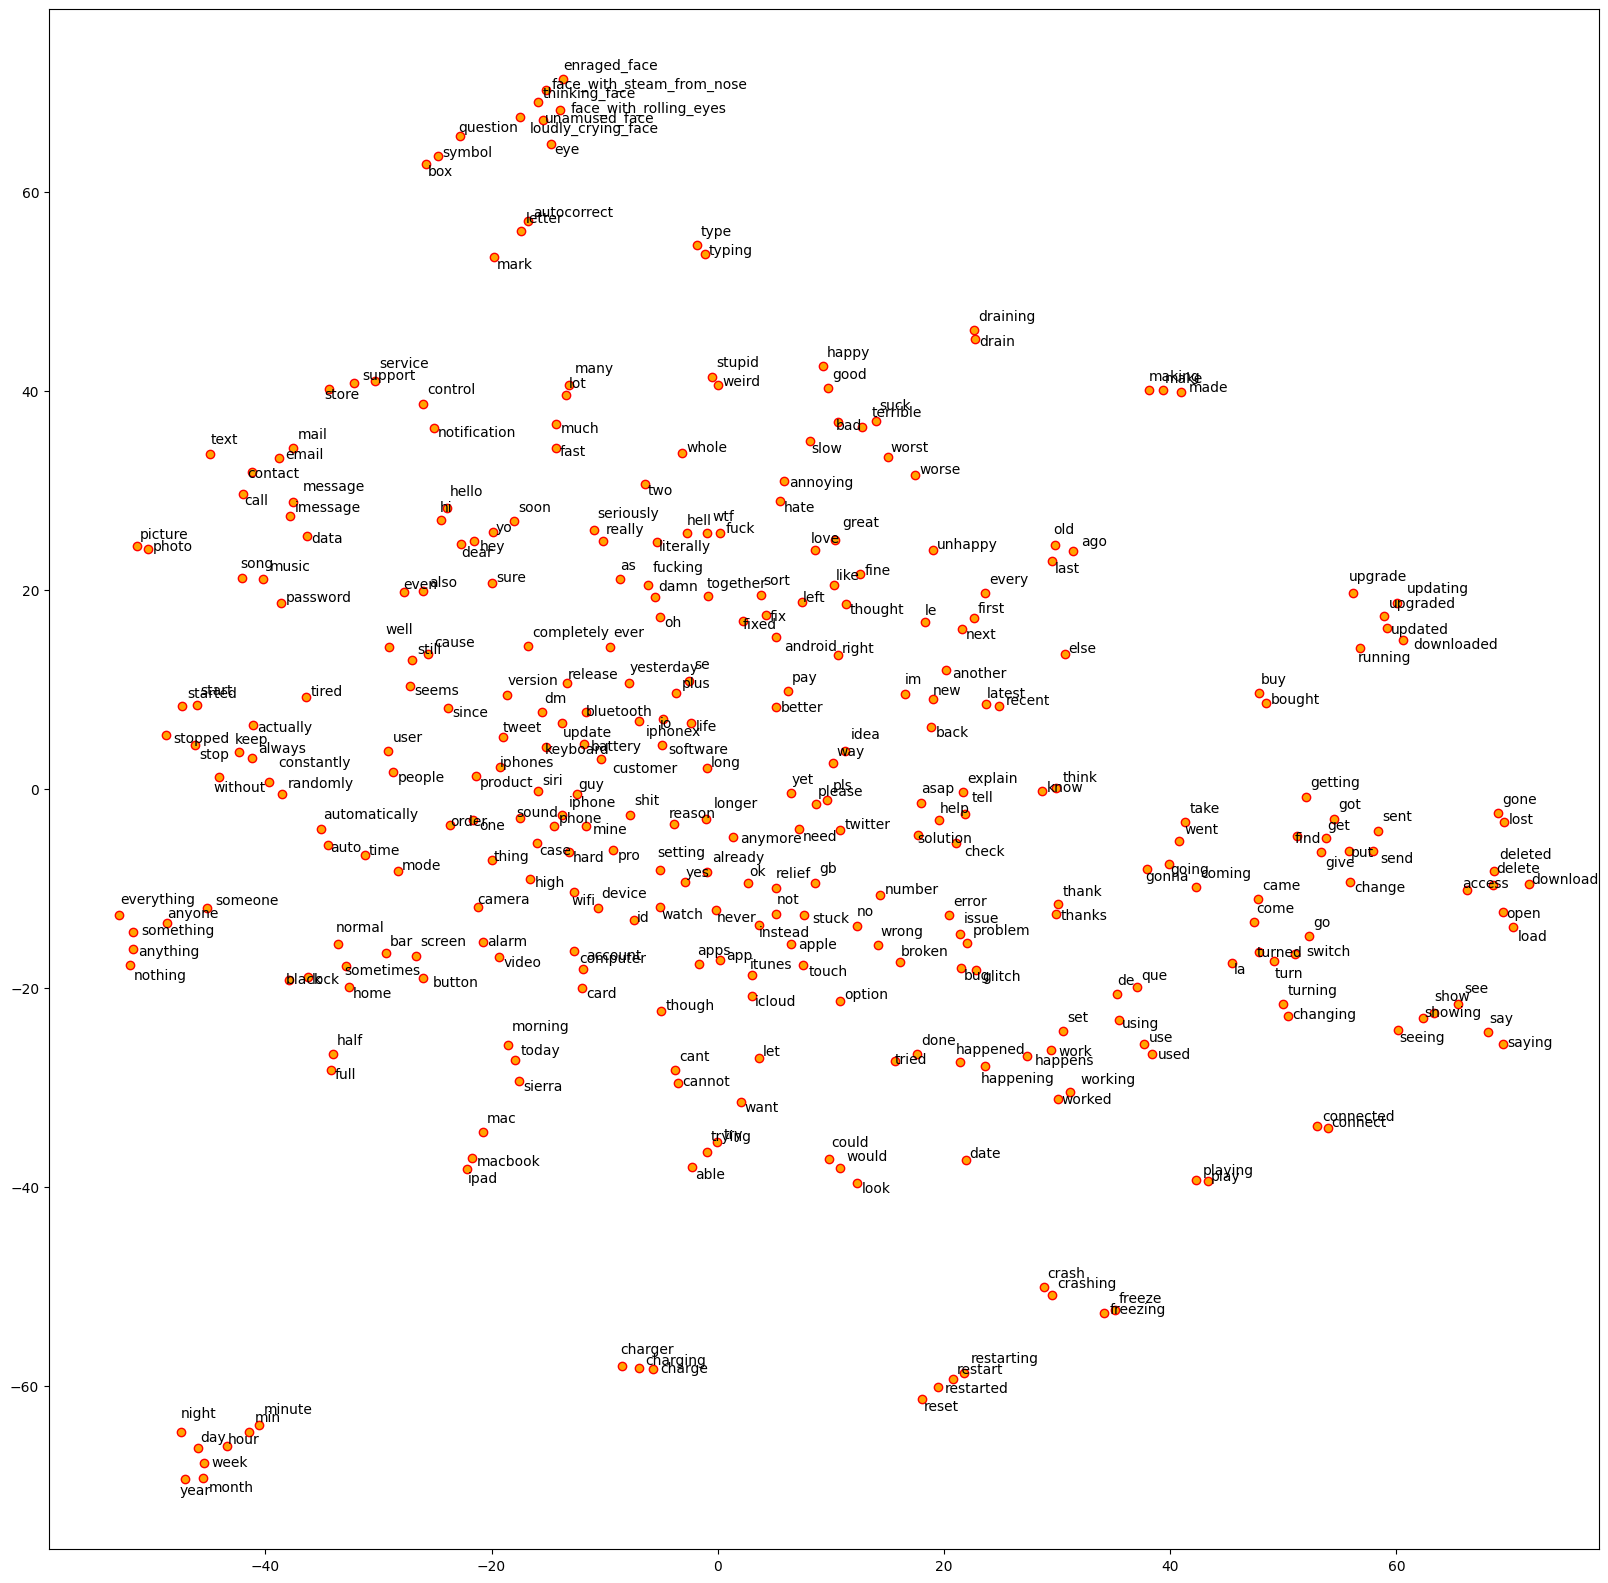

In [ ]:
visualize_word_embedding(top_words_new, top_words_vector_ls)

In [ ]:
cleaned_data[cleaned_data.str.contains("bluetooth")]

62                                                                                                                               still no reliable bluetooth iphone
343                                                                                                                             updated iphone bluetooth constantly
441                                                                                                        . . . not tried yet little bluetooth sound bar home soon
442                                                               bluetooth connection iphone x infiniti terrible garbled scratchy cutting time not happen w iphone
475                          sometimes they're connected sometimes they're not sometimes even say bluetooth not available bar top yet one connected started updated
                                                                                    ...                                                                            
106446    dear u